In [41]:
import sys
import math
from metrics import evaluate_classification
from plots import plot_decision_boundary, plot_data

from sklearn.datasets import make_classification, make_moons
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time

LAST_NEURON = 1

In [42]:
class NeuralNet:
    def __init__(self, layer_dims, layer_activations, mini_batch_size = 1, keep_prob=1, patience = 100, normalize = True, learning_rate = 0.01, num_epochs = 30000):
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.normalize = normalize
        self.layer_dims = layer_dims
        self.layer_activations = layer_activations
        self.keep_prob = keep_prob
        self.mini_batch_size = mini_batch_size

        self.best_loss = np.inf
        self.patience = patience
        self.epochs_without_improvement = 0

        self.is_cost_binary: bool
        if layer_activations[-1] == 'softmax':
            self.is_cost_binary = False
        else:
            self.is_cost_binary = True
    
    def __initialize_parameters(self, layer_dims):
        np.random.seed(42)
        self.parameters={}

        L = len(layer_dims)
        for l in range(1, L):
            self.parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1])
            self.parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))

            assert(self.parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
            assert(self.parameters['b' + str(l)].shape == (layer_dims[l], 1))

    def __random_mini_batches(self, X, Y, mini_batch_size=1, seed=0):
        np.random.seed(seed)
        m = X.shape[1]
        mini_batches = []

        permutation = list(np.random.permutation(m))
        shuffled_X = X[:, permutation]
        shuffled_Y = Y[:, permutation].reshape((1, m))

        num_complete_minibatches = math.floor(m / mini_batch_size)

        for k in range(0, num_complete_minibatches):
            mini_batch_X = shuffled_X[:, mini_batch_size * k : mini_batch_size * (k + 1)]
            mini_batch_Y = shuffled_Y[:, mini_batch_size * k : mini_batch_size * (k + 1)]

            mini_batch = (mini_batch_X, mini_batch_Y)
            mini_batches.append(mini_batch)
    
        if m % mini_batch_size != 0:
            mini_batch_X = shuffled_X[:, mini_batch_size * num_complete_minibatches : mini_batch_size * (num_complete_minibatches + 1)]
            mini_batch_Y = shuffled_Y[:, mini_batch_size * num_complete_minibatches : mini_batch_size * (num_complete_minibatches + 1)]
        
            mini_batch = (mini_batch_X, mini_batch_Y)
            mini_batches.append(mini_batch)
        
        return mini_batches


    def __normalize(self, X, mean = None, std = None):
        n = X.shape[0]
        m = mean
        if m is None:
            m = np.mean(X, axis=1).reshape((n, 1))
        s = std
        if s is None:
            s = np.std(X, axis=1).reshape((n, 1))
        X_new = (X - m) / s
        return X_new, m, s

    def __softmax(self, Z):
        exp_z = np.exp(Z)
        A = exp_z / np.sum(exp_z, axis=0, keepdims=True)

        cache = Z

        return A, cache
    
    def __tanh(self, Z):
        A = (np.exp(Z) - np.exp(-Z)) / (np.exp(Z) + np.exp(-Z))
        cache = Z

        return A, cache

    def __relu(self, Z):
        A = np.maximum(0, Z)
        cache = Z

        assert(A.shape == Z.shape)

        return A, cache

    def __sigmoid(self, Z):
        A = 1 / (1 + np.exp(-Z))
        cache = Z

        return A, cache
    
    def __linear_forward(self, A, W, b):
        Z = W.dot(A) + b
        cache = (A, W, b)

        assert(Z.shape == (W.shape[0], A.shape[1]))
    
        return Z, cache

    def __linear_activation_forward(self, A_prev, W, b, activation, keep_prob=1):
        Z, linear_cache = self.__linear_forward(A_prev, W, b)
        if activation == "sigmoid":
            A, activation_cache = self.__sigmoid(Z)
        elif activation == "relu":
            A, activation_cache = self.__relu(Z)
        elif activation == "tanh":
            A, activation_cache = self.__tanh(Z)
        elif activation == "softmax":
            A, activation_cache = self.__softmax(Z)

        D = np.random.rand(A.shape[0], A.shape[1])
        D = (D < keep_prob).astype(int)
        A = A * D
        A = A / keep_prob

        cache = (linear_cache, activation_cache, D)

        assert (A.shape == (W.shape[0], A_prev.shape[1]))

        return A, cache
       
    def __forward_propagation(self, X, keep_prob=1):
        caches = []
        A = X
        L = len(self.parameters) // 2

        for l in range(1, L):
            A_prev = A
            A, cache = self.__linear_activation_forward(A_prev, self.parameters['W' + str(l)], self.parameters['b' + str(l)], activation = self.layer_activations[l - 1], keep_prob=keep_prob)
            caches.append(cache)
        
        AL, cache = self.__linear_activation_forward(A, self.parameters['W' + str(L)], self.parameters['b' + str(L)], activation = self.layer_activations[L - 1])
        caches.append(cache)


        return AL, caches
    
    def compute_cost_binary(self, A, Y):
        m = Y.shape[1]
        res = Y * np.log(A) + (1 - Y) * np.log(1 - A)
        J = -(1 / m) * np.sum(res)
        J = np.squeeze(J)

        assert(J.shape == ())

        return J
    
    def compute_cost_multi_class(self, A, Y):
        m = Y.shape[1]
        res = Y * np.log(A)
        J = -(1 / m) * np.sum(res)
        J = np.squeeze(J)

        assert(J.shape == ())

        return J
    
    def __softmax_backward(self, Y, cache):
        Z = cache
        dZ = Z - Y

        assert (dZ.shape == Z.shape)

        return dZ

    def __tanh_backward(self, dA, cache):
        Z = cache
        s = (1 - np.power(Z, 2))
        dZ = dA * s

        assert (dZ.shape == Z.shape)

        return dZ

    def __sigmoid_backward(self, dA, cache):
        Z = cache
        s = 1/(1+np.exp(-Z))
        dZ = dA * s * (1-s)

        assert (dZ.shape == Z.shape)

        return dZ
    
    def __relu_backward(self, dA, cache):
        Z = cache
        dZ = np.array(dA, copy=True)
        dZ[Z <= 0] = 0

        assert (dZ.shape == Z.shape)
        
        return dZ

    def __linear_backward(self, dZ, cache):
        A_prev, W, b = cache
        m = A_prev.shape[1]

        dW = 1./m * np.dot(dZ,A_prev.T)
        db = 1./m * np.sum(dZ, axis = 1, keepdims = True)
        dA_prev = np.dot(W.T,dZ)

        assert (dA_prev.shape == A_prev.shape)
        assert (dW.shape == W.shape)
        assert (db.shape == b.shape)
    
        return dA_prev, dW, db

    def __linear_activation_backward(self, dA, Y, cache, activation, keep_prob=1):
        linear_cache, activation_cache, D = cache
        dA = dA * D
        dA = dA / keep_prob
        if activation == "relu":
            dZ = self.__relu_backward(dA, activation_cache)
        elif activation == "sigmoid":
            dZ = self.__sigmoid_backward(dA, activation_cache)
        elif activation == "softmax":
            dZ = self.__softmax_backward(Y, activation_cache)
        elif activation == "tanh":
            dZ = self.__tanh_backward(dA, activation_cache)

        dA_prev, dW, db = self.__linear_backward(dZ, linear_cache)
    
        return dA_prev, dW, db

    def __backward_propagation(self, AL, Y, caches, keep_prob=1):
        grads = {}
        L = len(caches)
        m = AL.shape[1]
        
        dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))

        current_cache = caches[L-1]
        grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = self.__linear_activation_backward(dAL, Y, current_cache, activation = self.layer_activations[L - 1])

        for l in reversed(range(L-1)):
            current_cache = caches[l]
            dA_prev_temp, dW_temp, db_temp = self.__linear_activation_backward(grads["dA" + str(l + 1)], Y, current_cache, activation = self.layer_activations[l], keep_prob=keep_prob)
            grads["dA" + str(l)] = dA_prev_temp
            grads["dW" + str(l + 1)] = dW_temp
            grads["db" + str(l + 1)] = db_temp

        return grads
    
    def __update_parameters(self, grads):
        L = len(self.parameters) // 2

        for l in range(L):
            self.parameters["W" + str(l+1)] = self.parameters["W" + str(l+1)] - self.learning_rate * grads["dW" + str(l+1)]
            self.parameters["b" + str(l+1)] = self.parameters["b" + str(l+1)] - self.learning_rate * grads["db" + str(l+1)]

        
    def fit(self, X_vert, Y_vert, X_vert_test, Y_vert_test, print_cost = True):
        
        X, Y = X_vert.T, Y_vert.T
        X_test, Y_test = X_vert_test.T, Y_vert_test.T
        
        if self.normalize:
            X, self.__mean, self.__std = self.__normalize(X)
        
        costs = []
        self.__initialize_parameters(self.layer_dims)
        m = X.shape[1]
        seed = 0
        minibatch_size = self.mini_batch_size

        if self.is_cost_binary:
            cost_function = self.compute_cost_binary
        else:
            cost_function = self.compute_cost_multi_class

        for i in range(self.num_epochs + 1):

            seed = seed + 1
            minibatches = self.__random_mini_batches(X, Y, minibatch_size, seed)
            cost_total = 0
            val_cost_total = 0

            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch

                AL, caches = self.__forward_propagation(minibatch_X, self.keep_prob)

                cost_total += cost_function(AL, minibatch_Y)

                AL_test, _ = self.__forward_propagation(X_test, self.keep_prob)
                val_cost_total += cost_function(AL_test, Y_test)

                grads = self.__backward_propagation(AL, minibatch_Y, caches, self.keep_prob)

                self.__update_parameters(grads)

            cost_avg = cost_total / m
            val_cost_avg = val_cost_total / m

            if val_cost_avg < self.best_loss:
                self.best_loss = val_cost_avg
                self.epochs_without_improvement = 0
            else:
                self.epochs_without_improvement += 1

            # if self.epochs_without_improvement >= self.patience:
            #     print(f"Early stopping after {i} epochs.")
            #     break

            if print_cost and i % 1000 == 0:
                print("{}-th iteration: {}".format(i, cost_avg))

            if i % 100 == 0:
                costs.append(cost_avg)

        if print_cost:
            plt.plot(costs)
            plt.ylabel("Cost")
            plt.xlabel("Iteration, *100")
            plt.show()
    

    ### ???
    def predict_proba(self, X_vert, bool=True):
        X = X_vert.T
        if self.normalize:
            X, _, _ = self.__normalize(X, self.__mean, self.__std)
    
        probs, _ = self.__forward_propagation(X)

        if self.layer_activations[-1] == 'sigmoid':
            if not bool:
                return np.column_stack((1 - probs.T, probs.T))
            result = np.column_stack((1 - probs.T, probs.T))[:, 1].T
        elif self.layer_activations[-1] == 'softmax':
            result = probs.T
        else:
            raise ValueError("Unsupported activation function in the last layer")
    
        return result

    ### ???
    def predict(self, X_vert):
        positive_probs = self.predict_proba(X_vert)
        if (self.layer_activations[-1] == 'sigmoid'):
            result = (positive_probs >= 0.5).astype(int)
        elif self.layer_activations[-1] == 'softmax':
            result = np.argmax(positive_probs, axis=1).reshape(-1, 1)
        else:
            raise ValueError("Unsupported activation function in the last layer")
        return result


# Симульовані дані 1

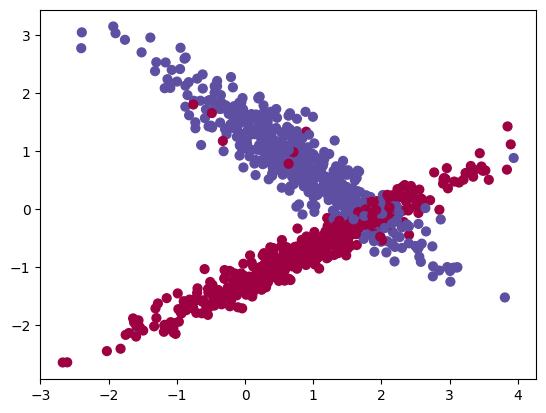

0-th iteration: 0.006001500868042167
1000-th iteration: 0.005878044678706004
2000-th iteration: 0.006079840290134391
3000-th iteration: 0.006119896157250435
4000-th iteration: 0.0060791359421038995
5000-th iteration: 0.006160119210689916


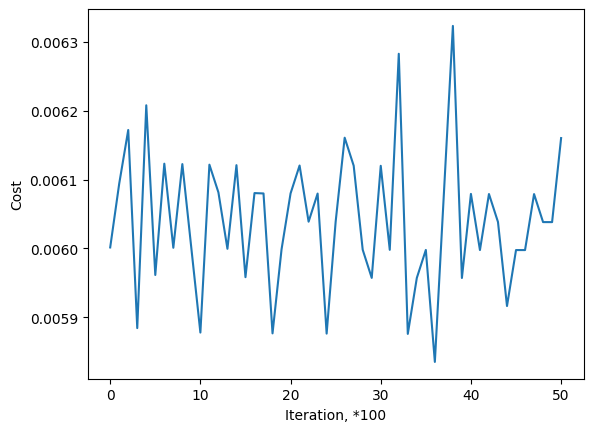

Accuracy: 
0.385
Report: 
              precision    recall  f1-score   support

           0       0.43      0.68      0.53       101
           1       0.20      0.08      0.12        99

    accuracy                           0.39       200
   macro avg       0.32      0.38      0.32       200
weighted avg       0.32      0.39      0.32       200

Confusion: 
    0   1
0  69  32
1  91   8


In [43]:
# X, y = make_classification(n_samples = 200, n_classes = 2, n_features = 2, 
#                            n_informative=2, n_redundant=0, random_state = 42,
#                            flip_y=0.02, class_sep=0.8) #n_clusters_per_class=1
X, y = make_classification(n_samples = 1000, n_classes = 2, n_features = 2, 
                           n_informative=2, n_redundant=0, random_state = 42,
                           flip_y=0.02, class_sep=0.8, n_clusters_per_class=1)
y = y.reshape(-1, 1)

plot_data(X, y)
plt.show()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2 'softmax' 1 'sigmoid'

layer_dims_1 = [X.shape[1], 20, 20, 20, 20, 20, 2]
layer_activations_1 = ['relu', 'relu', 'relu', 'relu', 'relu', 'softmax']
mini_batch_size_1 = 128
keep_prob_1 = 0.9
patience_1 = 100

nn = NeuralNet(layer_dims_1, layer_activations_1, mini_batch_size=mini_batch_size_1, keep_prob=keep_prob_1, patience=patience_1, learning_rate=0.01, num_epochs=5000)
nn.fit(X_train, y_train, X_test, y_test)

y_test_pred = nn.predict(X_test)

accuracy, report, confusion = evaluate_classification(y_test, y_test_pred)
print(f"Accuracy: \n{accuracy}")
print(f"Report: \n{report}")
print(f"Confusion: \n{confusion}")
if layer_dims_1[-1] == 1:
    plot_decision_boundary(nn, X_test, y_test)
plt.show()

# Test Field for Softmax

In [44]:
import os
import tensorflow as tf
from tensorflow import keras

In [45]:
mean = np.mean(X_train)
std = np.std(X_train)

X_train_normalized = (X_train - mean) / std

model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(units=20, activation=tf.nn.relu),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(units=20, activation=tf.nn.relu),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(units=20, activation=tf.nn.relu),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(units=20, activation=tf.nn.relu),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(units=20, activation=tf.nn.relu),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(units=3, activation=tf.nn.softmax)
])

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

model.compile(optimizer=optimizer,                   
                loss='sparse_categorical_crossentropy',                   
                metrics=['accuracy'])

history = model.fit(X_train_normalized, y_train, epochs=300, batch_size=128)

Epoch 1/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1413 - loss: 1.1319
Epoch 2/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2870 - loss: 1.1121 
Epoch 3/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3485 - loss: 1.0930 
Epoch 4/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3925 - loss: 1.0782 
Epoch 5/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3894 - loss: 1.0631 
Epoch 6/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4136 - loss: 1.0494 
Epoch 7/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4388 - loss: 1.0352 
Epoch 8/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4583 - loss: 1.0240 
Epoch 9/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4441 - loss: 1.0144 
Epoch 10/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4133 - loss: 1.0055 
Epoch 11/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4158 - loss: 0.9927 
Epoch 12/300
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4487 - loss

# Симульовані дані 2

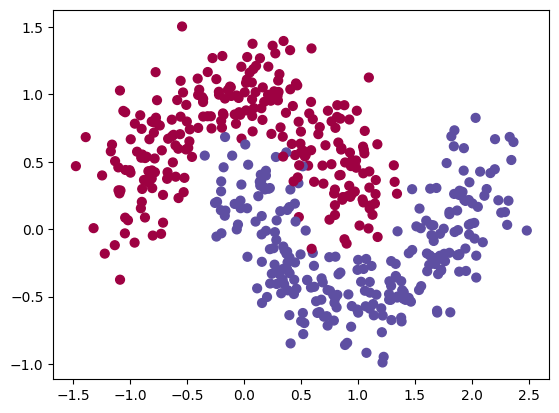

0-th iteration: 0.023049971359596886
1000-th iteration: 0.01130571960674748


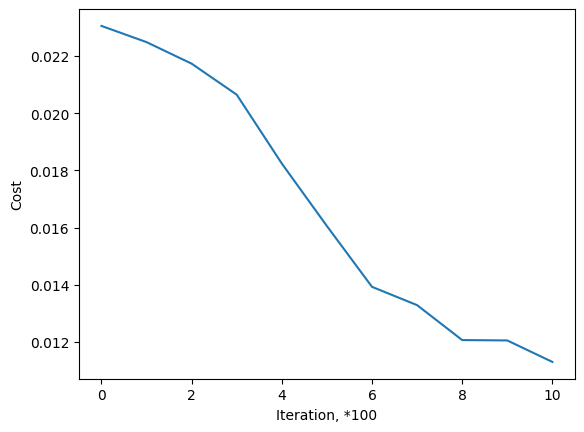

Accuracy: 
0.85
Report: 
              precision    recall  f1-score   support

           0       0.77      0.93      0.84        43
           1       0.94      0.79      0.86        57

    accuracy                           0.85       100
   macro avg       0.85      0.86      0.85       100
weighted avg       0.87      0.85      0.85       100

Confusion: 
    0   1
0  40   3
1  12  45


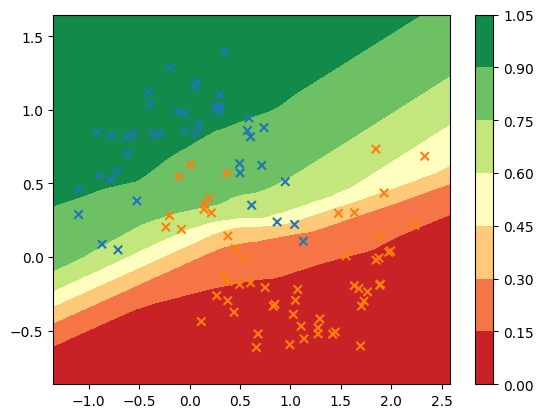

In [46]:
X, y = make_moons(n_samples=500, noise=0.2, random_state=42)
y = y.reshape(-1, 1)

plot_data(X, y)
plt.show()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

layer_dims_2 = [X.shape[1], 10, 10, 5, LAST_NEURON]
layer_activations_2 = ['relu', 'relu', 'relu', 'sigmoid']
mini_batch_size_2 = 32
keep_prob_2 = 0.9
patience_2 = 2000

nn = NeuralNet(layer_dims_2, layer_activations_2, mini_batch_size=mini_batch_size_2, keep_prob=keep_prob_2, patience=patience_2, learning_rate = 0.001, num_epochs=1000)
nn.fit(X_train, y_train, X_test, y_test)

y_test_pred = nn.predict(X_test)

accuracy, report, confusion = evaluate_classification(y_test, y_test_pred)
print(f"Accuracy: \n{accuracy}")
print(f"Report: \n{report}")
print(f"Confusion: \n{confusion}")
if layer_dims_2[-1] == 1:
    plot_decision_boundary(nn, X_test, y_test)
plt.show()

# Tests dataset

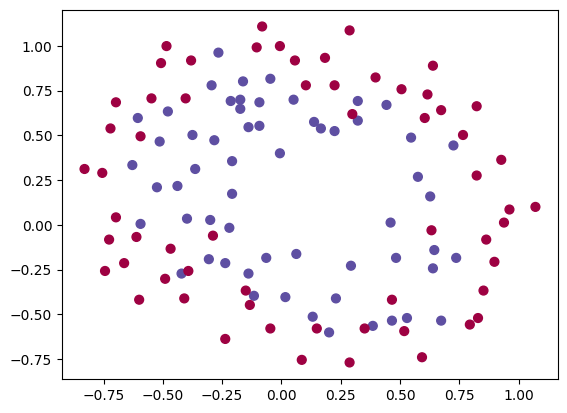

In [47]:
data_columns = ["test1", "test2"]
target_column = "passed"
df = pd.read_csv("tests.csv")
X, y = df[data_columns].values, df[target_column].values
y = y.reshape(-1, 1)

plot_data(X, y)
plt.show()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

0-th iteration: 0.02146600196446272
1000-th iteration: 0.020229455364449627
2000-th iteration: 0.016023625266876448
3000-th iteration: 0.016142859164017403
4000-th iteration: 0.013768374239224212
5000-th iteration: 0.013119717148020679


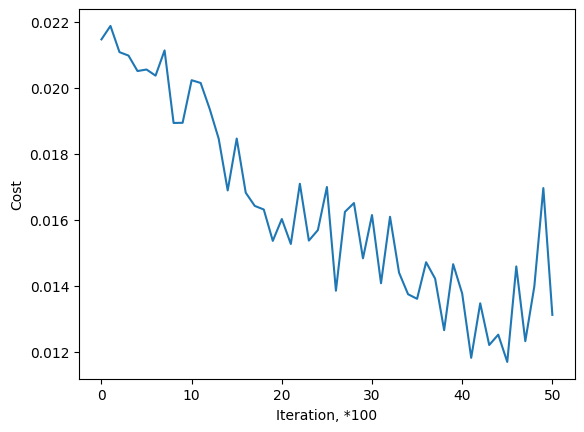

Accuracy: 
0.875
Report: 
              precision    recall  f1-score   support

           0       1.00      0.75      0.86        12
           1       0.80      1.00      0.89        12

    accuracy                           0.88        24
   macro avg       0.90      0.88      0.87        24
weighted avg       0.90      0.88      0.87        24

Confusion: 
   0   1
0  9   3
1  0  12


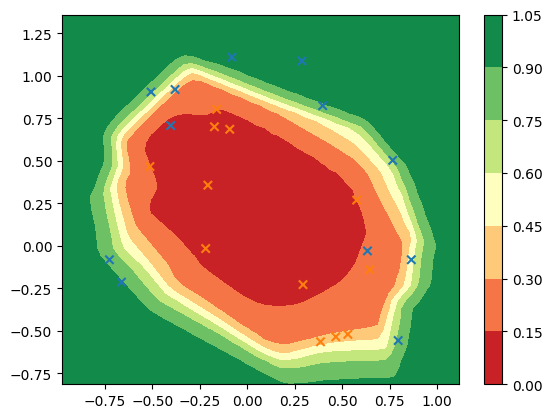

In [48]:
layer_dims_3 = [X.shape[1], 10, 10, 5, LAST_NEURON]
layer_activations_3 = ['relu', 'relu', 'relu', 'sigmoid']
mini_batch_size_3 = 32
keep_prob_3 = 0.9
patience_3 = 500

nn = NeuralNet(layer_dims_3, layer_activations_3, mini_batch_size=mini_batch_size_3, keep_prob=keep_prob_3, patience=patience_3, normalize = True, learning_rate = 0.01, num_epochs=5000)
nn.fit(X_train, y_train, X_test, y_test)

y_test_pred = nn.predict(X_test)

accuracy, report, confusion = evaluate_classification(y_test, y_test_pred)
print(f"Accuracy: \n{accuracy}")
print(f"Report: \n{report}")
print(f"Confusion: \n{confusion}")
if layer_dims_3[-1] == 1:
    plot_decision_boundary(nn, X_test, y_test)
plt.show()

In [49]:
print(nn.parameters)

{'W1': array([[ 0.91840996, -0.39797638],
       [ 0.50000161,  1.37687726],
       [-0.17304503, -0.04276141],
       [ 1.04587181,  0.84056109],
       [-0.14593144,  0.02235049],
       [-0.51545215, -0.35364309],
       [ 0.34421866, -1.43585144],
       [-1.50342728, -0.40466552],
       [-0.7602142 ,  0.7849456 ],
       [-0.69614716, -1.30744262]]), 'b1': array([[-6.48186097e-01],
       [-5.28851453e-01],
       [ 9.88320368e-02],
       [-6.77717570e-01],
       [-6.21571276e-03],
       [-3.71834229e-01],
       [ 2.11128670e-05],
       [-3.01753354e-01],
       [-4.17505154e-02],
       [-2.35750178e-01]]), 'W2': array([[ 0.70665862,  0.05098298,  0.02550772, -0.40187751, -0.15581308,
         0.03663713, -0.3433533 ,  0.19089706, -0.35959934, -0.09854424],
       [-0.16951047,  0.94582394, -0.06248995, -0.43240091,  0.20008096,
        -0.39234738,  0.08971935, -0.63731105, -0.59214889,  0.04914569],
       [ 0.22866952,  0.04104632, -0.01093876, -0.18222174, -0.44552297,


Зверніть увагу на границю прийняття рішення. Модель старається побудувати складну криву, що може свідчити про її перетренування. Порівняйте отримані результати з класом з sklearn. Спробуйте додати нові шари для нашого класу та порівняти результати тоді. Поекспериментуйте з гіперпараметрами для обох класів.

In [52]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes = (20,), max_iter = 10000)#, activation = 'logistic', solver = 'sgd', learning_rate_init = 0.01, learning_rate = 'constant')

clf.fit(X_train, y_train.ravel())
y_test_pred = clf.predict(X_test)

accuracy, report, confusion = evaluate_classification(y_test, y_test_pred)
print(f"Accuracy: \n{accuracy}")
print(f"Report: \n{report}")
print(f"Confusion: \n{confusion}")
plt.show()

Accuracy: 
0.7916666666666666
Report: 
              precision    recall  f1-score   support

           0       0.77      0.83      0.80        12
           1       0.82      0.75      0.78        12

    accuracy                           0.79        24
   macro avg       0.79      0.79      0.79        24
weighted avg       0.79      0.79      0.79        24

Confusion: 
    0  1
0  10  2
1   3  9


In [ ]:
clf.n_iter_

1792